# Семинар 2: Свертка изображений

## Вступление
На ближайших семинарах мы научимся решать некоторые задачи компьютерного зрения при помощи нейронных сетей. Основной инструмент работы в этой области — свёртки. С ними мы сегодня и познакомимся.

### План семинара
1. Учимся работать с картинками средствами **Python**, **NumPy** и **PyTorch**
2. Применяем константные свёртки к изображениям
3. Сравниваем работу полносвязных и свёрточных сетей на датасете MNIST


In [ ]:
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from matplotlib import cm

# !pip install Pillow
from PIL import Image
from torch import nn

# В этом модуле примерно все те же самые операторы, что и в `torch.nn`,
# но только представлениы они не в виде классов, а виде функций.
from torch.nn.functional import conv2d
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Учимся работать с картинками средствами **Python**, **NumPy** и **PyTorch**

### Загружаем изображение с диска

In [ ]:
# при работе в колабе, скачайте изображение этой командой
!wget https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg

--2025-04-05 15:19:29--  https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73801 (72K) [image/jpeg]
Saving to: ‘butterfly.jpg’

butterfly.jpg       100%[===================>]  72.07K  --.-KB/s    in 0.02s   

2025-04-05 15:19:29 (3.30 MB/s) - ‘butterfly.jpg’ saved [73801/73801]



Image format: JPEG; shape: (640, 427); color scheme: RGB


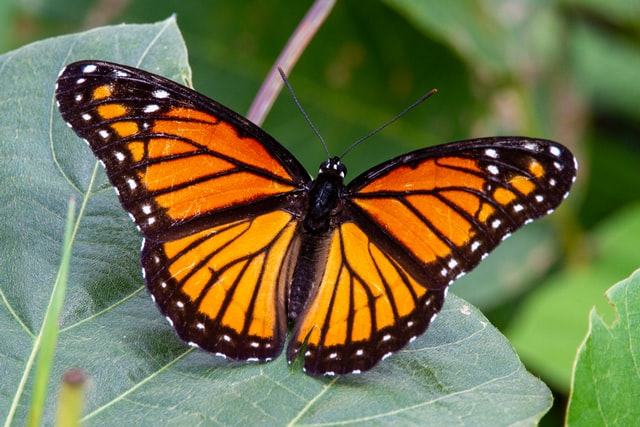

In [ ]:
img = Image.open("./butterfly.jpg")
print(f"Image format: {img.format}; shape: {img.size}; color scheme: {img.mode}")
img

### Матричное представление изображения

Мы знаем, что цветное изображение состоит из 3 числовых матриц или трехмерного тензора. Каждая матрица соответствует одному из 3 базовых цветов: красному, зеленому и синему.

Image array shape: (427, 640, 3)


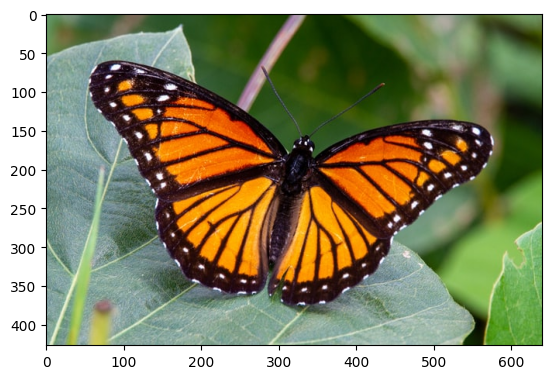

In [ ]:
# преобразуем изображение в массив
img_matrix = np.array(img)

# (высота, ширина, число каналов)
print(f"Image array shape: {img_matrix.shape}")

plt.imshow(img_matrix)
plt.show()

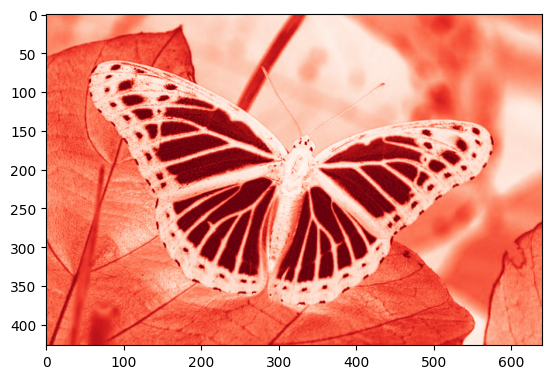

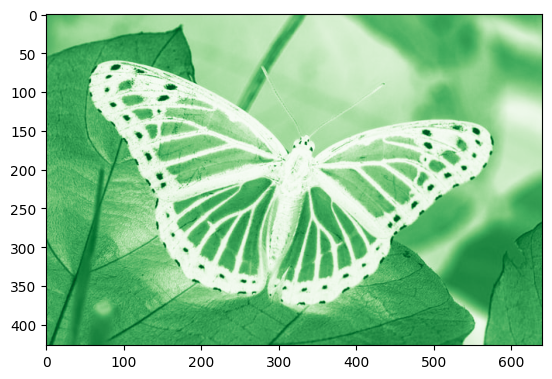

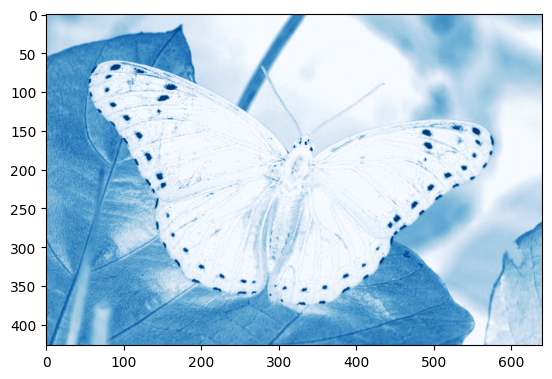

In [ ]:
# посмотрим на все каналы изображения отдельно
plt.imshow(img_matrix[:, :, 0], cmap=cm.Reds)
plt.show()

plt.imshow(img_matrix[:, :, 1], cmap=cm.Greens)
plt.show()

plt.imshow(img_matrix[:, :, 2], cmap=cm.Blues)
plt.show()

## 2. Применяем константные свёртки к изображениям

### Класс torch.nn.Conv2d

In [ ]:
nn.Conv2d

torch.nn.modules.conv.Conv2d

В **PyTorch** свёрточный слой представлен в модуле `torch.nn` классом [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с параметрами:
- `in_channels`: количество входных каналов
- `out_channels`: количество выходных каналов
- `kernel_size`: размер ядра
- `stride`: шаг
- `padding`: паддинг
- `padding_mode`: режим паддинга  (`'zeros'`, `'reflect'` и др.)
- `dilation`: растяжение

#### `kernel_size`

**Размер ядра**. `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свёртка изображения.

**`kernel_size=3`**

![no_padding_no_strides.gif](static/no_padding_no_strides.gif)

Эта и следующие анимации взяты [здесь](https://github.com/vdumoulin/conv_arithmetic).

#### `stride`

**Шаг**. Задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

**`stride=2`**

![no_padding_strides.gif](static/no_padding_strides.gif)

#### `padding`

**Паддинг**. Количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**`padding=1`**

![same_padding_no_strides.gif](static/same_padding_no_strides.gif)

### Свёртка изображений

Чем может быть полезна свертка при работе с изображениями? Свертки детектируют **паттерны на картинках** – цвета и сочетания цветов, небольшие объекты. Обычно значения свертки являются обучаемыми параметрами нейрости. Однако существуют "готовые" свертки, настроенные на определенные паттерны.

Например, оператор Собеля (свертка с определенными параметрами) используется для детекции границ на изображении. Применим этот оператор. Для этого пока не будем пользоваться классом `torch.nn.Conv2d`, а возьмём соответствующую функцию из модуля `torch.nn.functional`.

Конвертируем изображение в тензор и переставим размерности в порядке `(batch_size, n_channels, height, width)`, который принят в **PyTorch**.

In [ ]:
img_matrix.shape

(427, 640, 3)

In [ ]:
img_tensor = torch.tensor(img_matrix, dtype=torch.float)
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
img_tensor.size()

torch.Size([1, 3, 427, 640])

Зададим оператор Собеля для детектирования горизонтальных границ

In [ ]:
sobel_hor = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

# одна матрица на каждый канал картинки
kernel = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()

torch.Size([1, 3, 3, 3])

In [ ]:
# свернём картинку с подготовленным ядром свёртки
img_conv_hor = conv2d(img_tensor, kernel)
img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size()

torch.Size([1, 425, 638, 1])

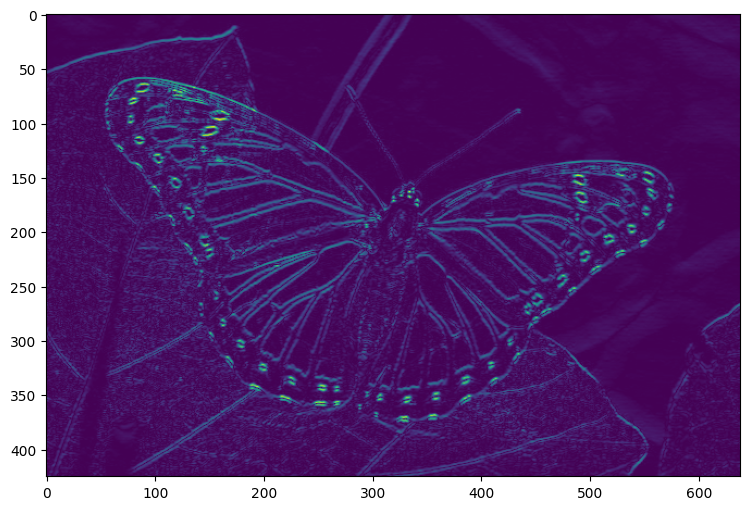

In [ ]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]))
plt.show()

Проделаем то же самое для детектирования вертикальных границ

In [ ]:
sobel_ver = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

# одна матрица на каждый канал картинки
kernel = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)

img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size()

torch.Size([1, 425, 638, 1])

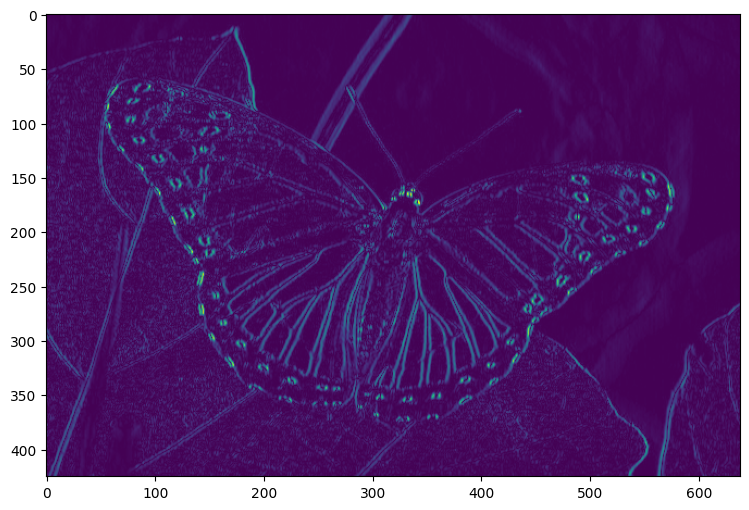

In [ ]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

Объединим два изображения

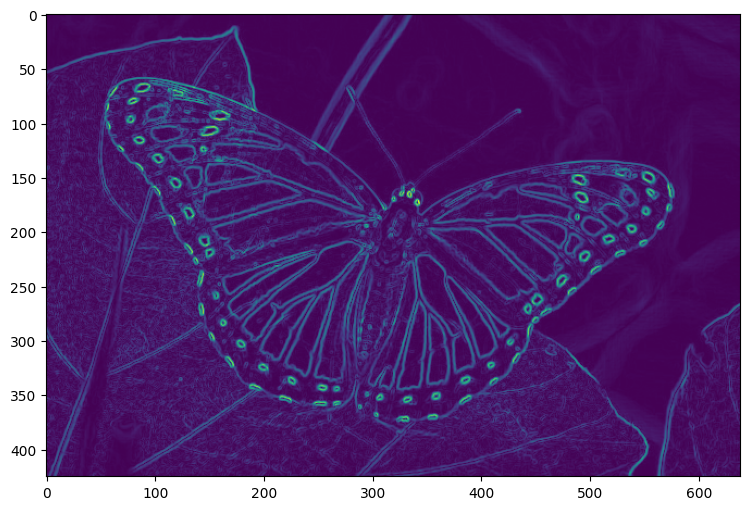

In [ ]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(img_conv[0, :, :, 0])
plt.show()

### Задание 1
По аналогии с примером выше, сверните изображение со случайным ядром такого же размера.

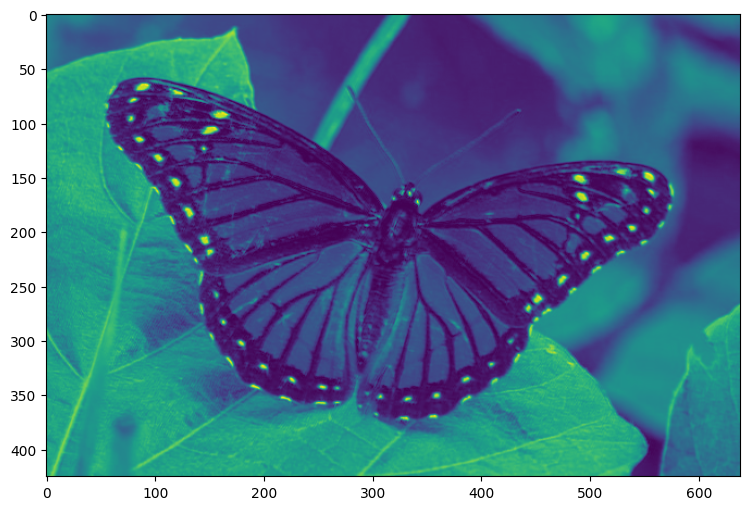

In [ ]:
### YOUR CODE HERE
kernel = torch.randn(1, 3, 3, 3)
img_conv_random = conv2d(img_tensor, kernel)
img_conv_random = img_conv_random.permute(0, 2, 3, 1)

# рисуем результат
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_random[0, :, :, 0]))
plt.show()

### Сравниваем работу полносвязных и свёрточных сетей на датасете MNIST

Сначала решим задачу классификации изображений полносвязной нейронной сетью из прошлого семинара.

Скачаем и подготовим уже знакомые нам данные для классификации.

In [ ]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

mnist_train = MNIST("./mnist/", train=True, download=True, transform=transform)
mnist_val = MNIST("./mnist/", train=False, download=True, transform=transform)


train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = DataLoader(mnist_val, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.47MB/s]


Подготовим цикл обучения.

In [ ]:
def train(model, optimizer, n_epochs=5, wandb_project=None):
    """Функция, в которой проходит обучение нейросети.

    Parameters
    ----------
    model : nn.Module
        Нейросеть для обучения.
    optimizer : torch.optim.Optimizer
        Алгоритм оптимизации гиперпараметров (например, SGD)
    n_epochs : int, default 5
        Количество эпох для обучения нейросети. Эпоха – проход по объектам
        датасета алгоритмом оптимизации с обновлением гиперпараметров.
    wandb_project : str, default None
        Название проекта в wandb для логирования процесса обучения
        (опционально).
    """
    # подключаем wandb
    if wandb_project:
        import wandb

        wandb.init(project=wandb_project)
        wandb.watch(model)

    for epoch in range(n_epochs):
        # тренировка
        model.train()
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []

            # отключается весь функционал расчета градиентов
            model.eval()
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend(
                        (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
                    )

            if wandb_project:
                wandb.log(
                    {
                        "mean val loss": np.mean(val_loss),
                        "mean val accuracy": np.mean(val_accuracy),
                    }
                )

            # печатаем метрики
            print(
                f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}"
            )

Обучим полносвязную архитектуру.

In [ ]:
model = nn.Sequential(
    nn.Flatten(),  # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(
        28 * 28, 128
    ),  # линейный слой, преобразующий вектор размера 784 в вектор размера 128
    nn.ReLU(),  # нелинейность
    nn.Linear(
        128, 10
    ),  # линейный слой, преобразующий вектор размера 128 в вектор размера 10
)

optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01, fused=True
)  # создаем оптимизатор и передаем туда параметры модели

In [ ]:
print(
    f"Training model with {sum([x[1].numel() for x in model.named_parameters()])} parameters"
)
train(model, optimizer, wandb_project=None)

Training model with 101770 parameters


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.3173567056655884, accuracy: 0.9131


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.22454996407032013, accuracy: 0.9352


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.18114687502384186, accuracy: 0.9476


Изменим архитектуру, добавив в неё свёрточные слои.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(
        in_channels=1, out_channels=10, kernel_size=5
    ),  # добавим свёрточный слой с 10 ядрами
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),  # уменьшим картинку в 4 раза по каждой стороне
    nn.Flatten(),  # превращаем картинку 6х6х10 в вектор размером 360
    nn.Linear(
        6 * 6 * 10, 128
    ),  # линейный слой, преобразующий вектор размера 360 в вектор размера 128
    nn.ReLU(),  # нелинейность
    nn.Linear(
        128, 10
    ),  # отображение в пространство размерности числа меток классификации
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, fused=True)

In [ ]:
print(
    f"Training model with {sum([x[1].numel() for x in model.named_parameters()])} parameters"
)
train(model, optimizer, wandb_project=None)

Training model with 47758 parameters


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.2039613127708435, accuracy: 0.9418


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.10924942791461945, accuracy: 0.9655


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.10052856802940369, accuracy: 0.9663


### Задание 2

По аналогии с предыдущим примером, обучите нейронную сеть, у которой будут следующие слои:

- Свёрточный слой с 10 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Свёрточный слой с 20 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Полносвязный слой со 128 нейронами
- Функция активации ReLU
- Выходной слой

Напишите решение двумя способами:
 - с помощью класса `nn.Sequential`
 - в виде наследника класса `torch.nn.Module`

In [ ]:
# 1-й способ
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(4 * 4 * 20, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
)

In [ ]:
# 2-й способ


class ConvNetMNIST(nn.Module):

    def __init__(self):
        """Создание объекта класса. Через дополнительные аргументы можно
        изменять параметры слоев сети."""
        # инициализируем родителя
        super().__init__()

        # записываем в атрибуты составные части сети
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.relu = nn.ReLU()  # используется 3 раза
        self.pool = nn.MaxPool2d(kernel_size=2)  # используется 2 раза
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(4 * 4 * 20, 128)
        self.fc_2 = nn.Linear(128, 10)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Прямой проход по нейронной сети. Вычисление предсказаний."""
        pred = self.conv_1(x)
        pred = self.relu(pred)
        pred = self.pool(pred)
        pred = self.conv_2(pred)
        pred = self.relu(pred)
        pred = self.pool(pred)
        pred = self.flatten(pred)
        pred = self.fc_1(pred)
        pred = self.relu(pred)
        pred = self.fc_2(pred)

        return pred


model = ConvNetMNIST()

Код, написанный первым способом, более краткий и легче читается. Однако не все архитектуры можно представить в виде последовательного применения операторов из `torch.nn`. Также некоторые операторы могут повторяться. Поэтому чаще нейросеть записывается именно вторым способом, с помощью класса-наследника `nn.Module`.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
print(
    f"Training model with {sum([x[1].numel() for x in model.named_parameters()])} parameters"
)

train(model, optimizer)

Training model with 47658 parameters


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.1954309493303299, accuracy: 0.9422


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.07642834633588791, accuracy: 0.9744


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.061303794384002686, accuracy: 0.9803


# Доп. часть

Далее у нас было время, и мы решили поиграться. Посмотрели как выглядят обученные свертки

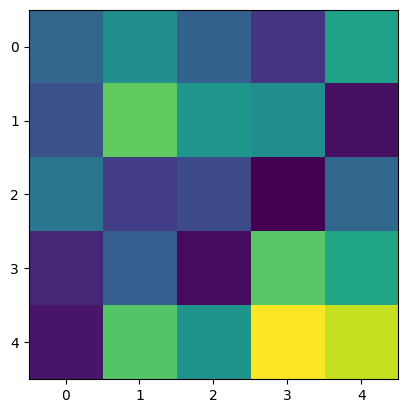

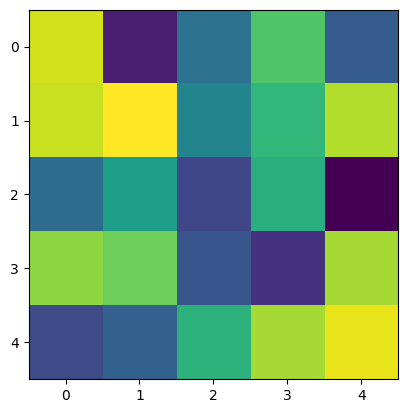

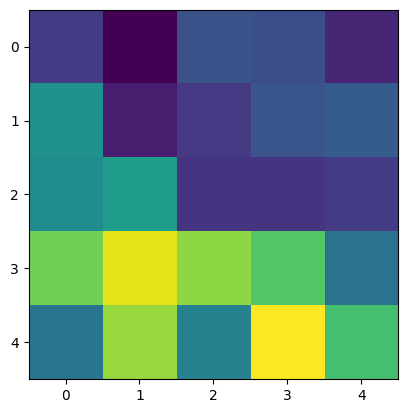

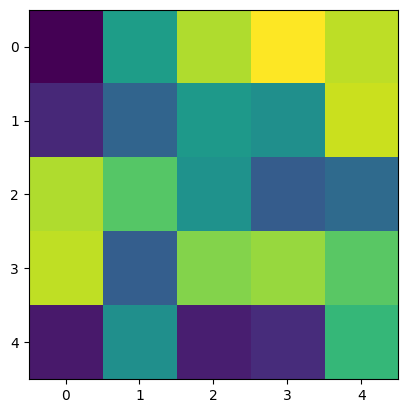

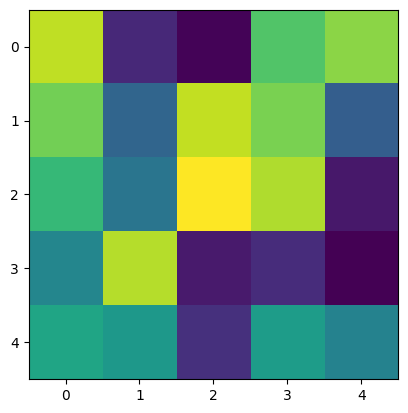

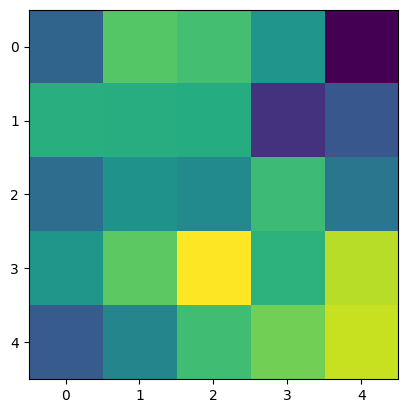

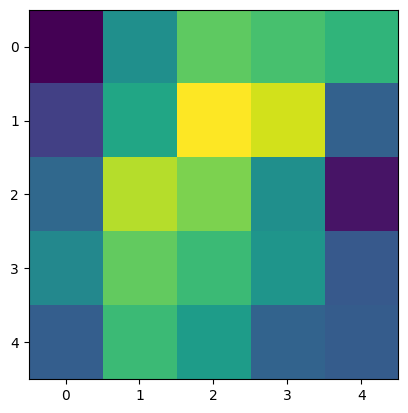

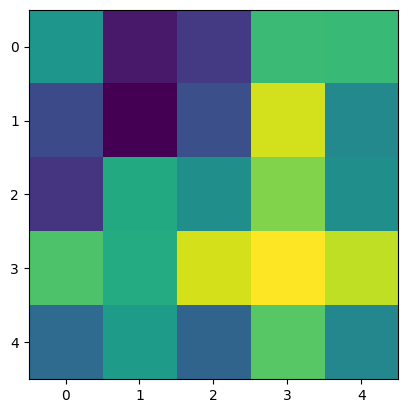

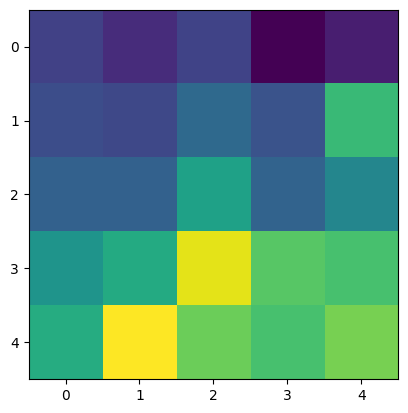

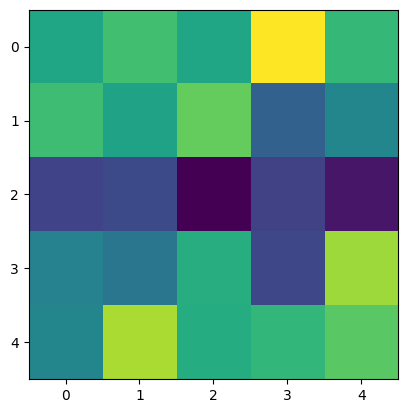

In [ ]:
for i in range(10):
    plt.imshow(model.conv_1.weight[i].detach().squeeze().numpy())
    plt.show()

# Ворнинг: далее код генерил чатгпт

Решили посмотреть, насколько похожи обученные свертки. Звучит логично, что одинаковые свертки = можно уменьшать количество параметров без особой потери качества. Получились довольно разные, но код взят от чата гпт, доверяйте с осторожностью

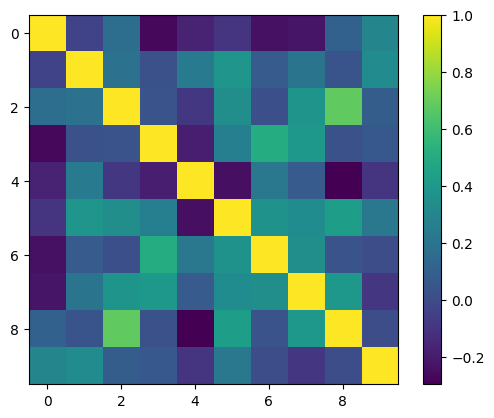

In [ ]:
def evaluate_kernel_diversity(conv_layer):
    """
    Evaluates the diversity of kernels in a convolutional layer by computing
    the average pairwise cosine similarity between the flattened filters.

    Args:
        conv_layer (torch.nn.Conv2d): The convolutional layer whose kernels are evaluated.

    Returns:
        avg_similarity (float): The average cosine similarity between different filters.
        similarity_matrix (torch.Tensor): A matrix of cosine similarities between all filters.
    """
    # Get the convolution weights: shape [out_channels, in_channels, kernel_height, kernel_width]
    weights = conv_layer.weight.data.clone()  # Clone to avoid in-place modifications
    out_channels, in_channels, kH, kW = weights.shape

    # Flatten each filter to a vector of size (in_channels * kH * kW)
    flattened_filters = weights.view(out_channels, -1)

    # Normalize each filter to have unit norm so that cosine similarity is equivalent to dot product
    flattened_filters = F.normalize(flattened_filters, p=2, dim=1)

    # Compute the cosine similarity matrix: each element (i, j) is the cosine similarity between filter i and j
    similarity_matrix = flattened_filters @ flattened_filters.t()

    # Since the diagonal is 1 (each filter with itself), we consider only the off-diagonal elements.
    num_filters = out_channels
    # Get indices for the upper triangle of the matrix (excluding the diagonal)
    indices = torch.triu_indices(num_filters, num_filters, offset=1)
    similarities = similarity_matrix[indices[0], indices[1]]

    # Compute the average similarity across all unique filter pairs
    avg_similarity = similarities.mean().item()

    return avg_similarity, similarity_matrix


a, b = evaluate_kernel_diversity(model.conv_1)
plt.imshow(b)
plt.colorbar()

Давайте теперь возьмем готовую архитектуру, а не будем своими руками писать. Вот как это можно сделать на примере датасета повеселее:

In [ ]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
        ),
    ]
)

base_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
        ),
    ]
)

cifar_train = torchvision.datasets.CIFAR10(
    root="./cifar", train=True, download=True, transform=transform
)
cifar_val = torchvision.datasets.CIFAR10(
    root="./cifar", train=False, download=True, transform=base_transform
)

train_dataloader = torch.utils.data.DataLoader(
    cifar_train, batch_size=32, shuffle=True, num_workers=4
)
val_dataloader = torch.utils.data.DataLoader(
    cifar_val, batch_size=32, shuffle=False, num_workers=4
)

100%|██████████| 170M/170M [00:01<00:00, 89.0MB/s]


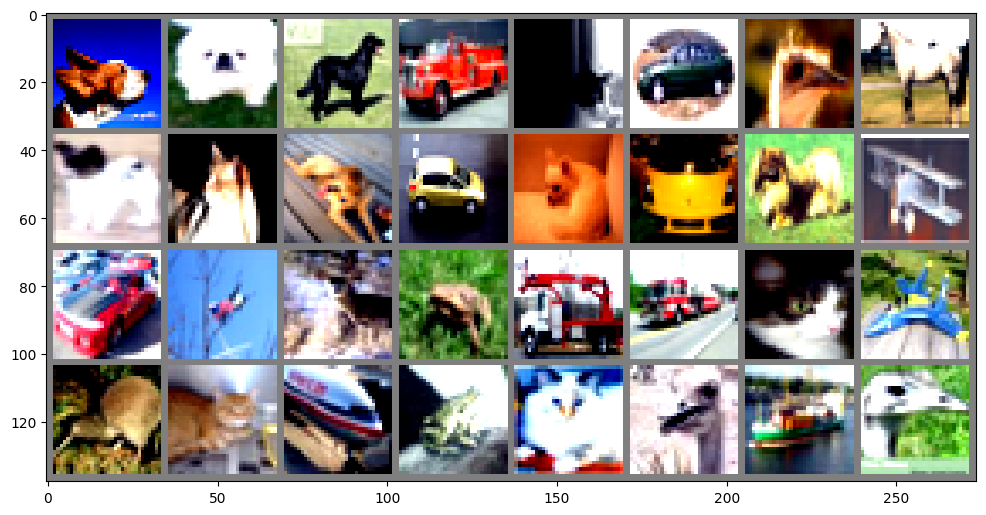

In [ ]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12, 12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

In [ ]:
images.size()

torch.Size([32, 3, 32, 32])

In [ ]:
model = torchvision.models.vgg11_bn(weights=None)

In [ ]:
model.classifier[6] = nn.Linear(4096, 10)

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
def train(model, optimizer, n_epochs=5, wandb_project=None):
    """Функция, в которой проходит обучение нейросети.

    Parameters
    ----------
    model : nn.Module
        Нейросеть для обучения.
    optimizer : torch.optim.Optimizer
        Алгоритм оптимизации гиперпараметров (например, SGD)
    n_epochs : int, default 5
        Количество эпох для обучения нейросети. Эпоха – проход по объектам
        датасета алгоритмом оптимизации с обновлением гиперпараметров.
    wandb_project : str, default None
        Название проекта в wandb для логирования процесса обучения
        (опционально).
    """
    # подключаем wandb
    if wandb_project:
        import wandb

        wandb.init(project=wandb_project)
        wandb.watch(model)

    for epoch in range(n_epochs):
        # тренировка
        model.train()
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []

            # отключается весь функционал расчета градиентов
            model.eval()
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend(
                        (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
                    )

            if wandb_project:
                wandb.log(
                    {
                        "mean val loss": np.mean(val_loss),
                        "mean val accuracy": np.mean(val_accuracy),
                    }
                )

            # печатаем метрики
            print(
                f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}"
            )

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), fused=True)
train(model, optimizer)

  0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: 